In [1]:
import scanpy as sc 
import numpy as np 
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.preprocessing import LabelEncoder

In [2]:
disease_label=1

In [3]:
def load_adata(file_path):
    adata = sc.read_h5ad(file_path)
    return adata 

def map_disease_labels(adata, label_column, encoder_column): 
    encoder = LabelEncoder()  # Create a single instance of LabelEncoder 
    adata.obs[encoder_column] = encoder.fit_transform(adata.obs[label_column].values)  # Transform labels 
    mapping_disease_label = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))  # Store mapping 
    return adata, mapping_disease_label 

In [4]:
path = r"../data/raw/COVID_Haniffa21/haniffa21.processed.h5ad" 
adata_covid = load_adata(path) 

In [5]:
gene_mask = adata_covid.var['feature_types'] == 'Gene Expression' 
adata_rna = adata_covid[:, gene_mask] 
adata_covid_binary = adata_rna[adata_rna.obs['Status'].isin(['Covid', 'Healthy'])] 

In [6]:
del adata_covid_binary.obsm 
del adata_covid_binary.uns

In [7]:
adata_covid_binary, mapping_disease_label_covid_binary = map_disease_labels(adata=adata_covid_binary, 
                                                                            label_column='Status', 
                                                                            encoder_column='disease_label_binary') 

In [8]:
print(adata_covid_binary.obs.groupby('disease_label_binary', observed=True)['patient_id'].nunique())

disease_label_binary
0    90
1    23
Name: patient_id, dtype: int64


In [9]:
adata_covid_binary.layers['preprocessed']= adata_covid_binary.X.copy()  # Save the preprocessed data in a new layer 
adata_covid_binary.layers['raw_counts'] = adata_covid_binary.layers['raw'].copy() # saving raw counts and using it for  preprocessing 
adata_covid_binary.X = adata_covid_binary.layers['raw_counts'].copy() 

In [10]:
adata_covid_binary.var["mt"] = adata_covid_binary.var_names.str.startswith("MT-") 
adata_covid_binary.var["ribo"] = adata_covid_binary.var_names.str.startswith(("RPS", "RPL")) 
adata_covid_binary.var["hb"] = adata_covid_binary.var_names.str.contains("^HB[^(P)]") 
sc.pp.calculate_qc_metrics(adata_covid_binary, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False) 

In [11]:
patient_ids = adata_covid_binary.obs['patient_id'].unique()
adata_list = [adata_covid_binary[adata_covid_binary.obs['patient_id'] == pid].copy() for pid in patient_ids] 

In [12]:
# For each patient, get set of expressed genes (expressed in ≥1 cell)
expressed_genes_per_patient = []
for ad in adata_list:
    if hasattr(ad.X, "toarray"):
        expr = ad.X.toarray()
    else:
        expr = ad.X 
    gene_sum = expr.sum(axis=0)
    genes_expressed = set(ad.var_names[gene_sum > 0])
    expressed_genes_per_patient.append(genes_expressed)

# Intersection across all patients
common_genes = set.intersection(*expressed_genes_per_patient)
print(f"Number of genes expressed in all patients: {len(common_genes)}")

for i, ad in enumerate(adata_list):
    genes_to_keep = ad.var_names.isin(common_genes)
    adata_list[i] = ad[:, genes_to_keep].copy() 

Number of genes expressed in all patients: 12087


In [13]:
adata_list_filtered = [ad for ad in adata_list if ad.n_obs >= 1000]

Preprocessing using Groundgan

In [14]:
anndata = sc.concat(adata_list)
anndata.X.shape

(624325, 12087)

In [15]:
anndata = adata_covid_binary[adata_covid_binary.obs.disease_label_binary == disease_label]

In [16]:
anndata.shape

(97039, 24737)

(array([4., 5., 5., 1., 1., 5., 1., 0., 0., 1.]),
 array([  634. ,  1778.7,  2923.4,  4068.1,  5212.8,  6357.5,  7502.2,
         8646.9,  9791.6, 10936.3, 12081. ]),
 <BarContainer object of 10 artists>)

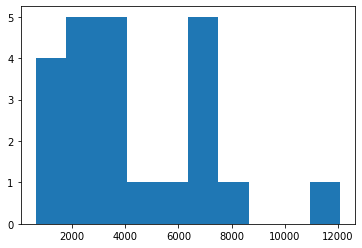

In [17]:
import matplotlib.pyplot as plt
plt.hist(anndata.obs.groupby('patient_id', observed=True)['patient_id'].size())

In [18]:
anndata.obs.groupby('patient_id', observed=True)['patient_id'].size().min(), anndata.obs.groupby('patient_id', observed=True)['patient_id'].size().max()

(634, 12081)

In [19]:
random_state=1000
import random
random.seed(random_state)

In [20]:
disease_class = 'covid' if disease_label == 0 else 'healthy'
disease_class

'healthy'

In [21]:
project_dir="/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN"
data_path = f"{project_dir}/data/processed/COVID_Haniffa21-GGpp-{disease_class}/CrossVal_{random_state}/"
print(data_path)

/home/c01teaf/CISPA-az6/llm_tg-2024/GRouNdGAN/data/processed/COVID_Haniffa21-GGpp-healthy/CrossVal_1000/


In [22]:
mkdir -p {data_path}

In [23]:
n_top_genes = 1000 # int(cfg.get("Preprocessing", "highly variable number"))
resolution = 0.15 # cfg.get("Preprocessing", "louvain res")
min_genes = 200 # int(cfg.get("Preprocessing", "min genes"))
min_cells = 3 # int(cfg.get("Preprocessing", "min cells"))
counts_per_cell_after = 20000 #int(cfg.get("Preprocessing", "library size"))
val_size = 1000 # int(cfg.get("Preprocessing", "validation set size"))
test_size = 1000 # int(cfg.get("Preprocessing", "test set size"))
path_to_train = f"{data_path}/train.h5ad" # cfg.get("Data", "train")
path_to_validation = f"{data_path}/validation.h5ad" # cfg.get("Data", "validation")
path_to_test = f"{data_path}/test.h5ad" # cfg.get("Data", "test")

In [24]:
test_size = int((anndata.obs.groupby('patient_id', observed=True)['patient_id'].size()*0.1).sum())
test_size

9703

In [25]:
original_order = np.arange(anndata.n_obs)  # Store the original cell order
np.random.shuffle(original_order)  # Shuffle the indices

# Apply the shuffled order to the AnnData object
anndata = anndata[original_order]

In [26]:
# clustering
ann_clustered = anndata.copy()
sc.pp.recipe_zheng17(ann_clustered,  n_top_genes=n_top_genes)
sc.tl.pca(ann_clustered, n_comps=50)
sc.pp.neighbors(ann_clustered, n_pcs=50)
sc.tl.louvain(ann_clustered, resolution=resolution)
anndata.obs["cluster"] = ann_clustered.obs["louvain"]

2025-09-25 14:19:31.809299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-09-25 14:19:31.809332: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Trying to set attribute `.obs` of view, copying.


In [27]:
anndata.obs['initial_clustering'].unique()

['CD8', 'CD4', 'NK_16hi', 'gdT', 'MAIT', ..., 'HSC', 'RBC', 'Lymph_prolif', 'Plasmablast', 'Mono_prolif']
Length: 18
Categories (18, object): ['B_cell', 'CD4', 'CD8', 'CD14', ..., 'RBC', 'Treg', 'gdT', 'pDC']

In [28]:
from collections import Counter

# get cluster ratios
cells_per_cluster = Counter(anndata.obs["cluster"])
cluster_ratios = dict()
for key, value in cells_per_cluster.items():
    cluster_ratios[key] = value / anndata.shape[0]
anndata.uns["cluster_ratios"] = cluster_ratios
anndata.uns["clusters_no"] = len(cluster_ratios)

In [29]:
# filtering
sc.pp.filter_cells(anndata, min_genes=min_genes)
sc.pp.filter_genes(anndata, min_cells=min_cells)
anndata.uns["cells_no"] = anndata.shape[0]
anndata.uns["genes_no"] = anndata.shape[1]

In [30]:
canndata = anndata.copy()

In [31]:
# library-size normalization
sc.pp.normalize_per_cell(canndata, counts_per_cell_after=counts_per_cell_after)

In [32]:
# identify highly variable genes
from scipy.sparse import issparse


sc.pp.log1p(canndata)  # logarithmize the data
sc.pp.highly_variable_genes(canndata, n_top_genes=n_top_genes)

if issparse(canndata.X):
    canndata.X = np.exp(canndata.X.toarray()) - 1  # get back original data
else:
    canndata.X = np.exp(canndata.X) - 1  # get back original data

anndata = anndata[
    :, canndata.var["highly_variable"]
]  # only keep highly variable genes

sc.pp.normalize_per_cell(anndata, counts_per_cell_after=counts_per_cell_after)

Trying to set attribute `.obs` of view, copying.


In [33]:
# sort genes by name (not needed)
sorted_genes = np.sort(anndata.var_names)
anndata = anndata[:, sorted_genes]

In [34]:
from sklearn.model_selection import train_test_split
import numpy as np

def split_data(anndata, label_column):
    y = anndata.obs[label_column].values
    X_idx = np.arange(anndata.n_obs)
    X_train, X_temp, y_train, y_temp = train_test_split(
                                        X_idx, 
                                        y, 
                                        test_size=test_size+val_size,
                                        random_state=random_state,
                                        stratify=y
                                    )
    X_val, X_test, y_val, y_test = train_test_split(
                                    X_temp, 
                                    y_temp,
                                    test_size=test_size,
                                    random_state=random_state,
                                    stratify=y_temp
                                )
    anndata_train = anndata[X_train].copy()
    anndata_val = anndata[X_val].copy()
    anndata_test = anndata[X_test].copy()
    return anndata_train, anndata_val, anndata_test

In [35]:
stratified_sampling = True

In [36]:
if stratified_sampling:
    label_column='patient_id'
    anndata_train, anndata_val, anndata_test = split_data(anndata, label_column)
else:
    anndata_val = anndata[:val_size]
    anndata_test = anndata[val_size : test_size + val_size]
    anndata_train = anndata[test_size + val_size :]

(array([4., 5., 5., 1., 1., 5., 1., 0., 0., 1.]),
 array([  63. ,  177.5,  292. ,  406.5,  521. ,  635.5,  750. ,  864.5,
         979. , 1093.5, 1208. ]),
 <BarContainer object of 10 artists>)

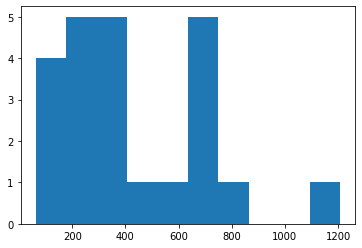

In [37]:
plt.hist(anndata_test.obs.groupby('patient_id', observed=True)['patient_id'].size())

In [38]:
len(anndata_test.obs.groupby('patient_id', observed=True)['patient_id'].size())

23

In [39]:
anndata_train.write_h5ad(path_to_train)
anndata_val.write_h5ad(path_to_validation)
anndata_test.write_h5ad(path_to_test)
    
####
print("Successfully preprocessed and and saved dataset")

Successfully preprocessed and and saved dataset


In [40]:
for split in [anndata_train, anndata_val, anndata_test]:
    print(split.obs[label_column].value_counts(normalize=True))
    print("---")

MH8919333      0.124502
MH8919332      0.082480
MH8919283      0.073168
MH8919178      0.072299
newcastle74    0.071430
MH8919282      0.071060
CV0904         0.070619
newcastle65    0.058272
MH8919179      0.044477
CV0902         0.040030
CV0934         0.035119
MH8919176      0.033150
CV0940         0.030486
CV0917         0.030138
CV0926         0.027022
MH8919177      0.022910
MH8919227      0.021602
CV0915         0.019992
CV0911         0.019633
CV0939         0.017710
CV0929         0.015104
MH8919226      0.012266
CV0944         0.006533
Name: patient_id, dtype: float64
---
MH8919333      0.124
MH8919332      0.083
MH8919283      0.073
newcastle74    0.072
MH8919178      0.072
CV0904         0.071
MH8919282      0.071
newcastle65    0.058
MH8919179      0.044
CV0902         0.040
CV0934         0.035
MH8919176      0.033
CV0940         0.030
CV0917         0.030
CV0926         0.027
MH8919177      0.023
MH8919227      0.022
CV0915         0.020
CV0911         0.020
CV0939      

In [41]:
for split in [anndata_train, anndata_val, anndata_test]:
    print(split.obs.groupby('disease_label_binary', observed=True)['patient_id'].nunique())
    print("---")

disease_label_binary
1    23
Name: patient_id, dtype: int64
---
disease_label_binary
1    23
Name: patient_id, dtype: int64
---
disease_label_binary
1    23
Name: patient_id, dtype: int64
---


In [42]:
#patient id in all splits
for split in [anndata_train, anndata_val, anndata_test]:
    print(len(split.obs['patient_id'].unique()))
    print("---")

23
---
23
---
23
---


In [43]:
for split in [anndata_train, anndata_val, anndata_test]:
    print(split.X.shape)
    print("---")

(86336, 1000)
---
(1000, 1000)
---
(9703, 1000)
---


In [44]:
for split in [anndata_train, anndata_val, anndata_test]:
    print(split.obs['initial_clustering'].unique())
    print(split.obs['initial_clustering'].value_counts())
    print("---")

['NK_16hi', 'CD4', 'CD8', 'CD14', 'RBC', ..., 'NK_56hi', 'Lymph_prolif', 'Plasmablast', 'HSC', 'Mono_prolif']
Length: 18
Categories (18, object): ['B_cell', 'CD4', 'CD8', 'CD14', ..., 'RBC', 'Treg', 'gdT', 'pDC']
CD4             25121
CD8             16727
NK_16hi         11254
CD14             9205
B_cell           6744
gdT              3146
CD16             3102
Treg             2075
NK_56hi          1953
DCs              1905
Platelets        1888
MAIT             1825
pDC               616
RBC               286
Lymph_prolif      255
HSC               131
Plasmablast        99
Mono_prolif         4
Name: initial_clustering, dtype: int64
---
['NK_16hi', 'CD4', 'CD8', 'CD14', 'gdT', ..., 'pDC', 'MAIT', 'Lymph_prolif', 'RBC', 'Plasmablast']
Length: 16
Categories (16, object): ['B_cell', 'CD4', 'CD8', 'CD14', ..., 'RBC', 'Treg', 'gdT', 'pDC']
CD4             328
CD8             206
NK_16hi         125
CD14             86
B_cell           79
gdT              36
Treg             30
NK_56h